## RNN FB Stock Price

Let’s start our Python script by importing our libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We will initially import the data set as a pandas DataFrame using the read_csv method. However, since the keras module of TensorFlow only accepts NumPy arrays as parameters, the data structure will need to be transformed post-import.
Let’s start by importing the entire .csv file as a DataFrame:

In [9]:
training_data = pd.read_csv('data/FB_training_data.csv')

In [10]:
training_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,78.580002,78.930000,77.699997,78.449997,78.449997,18177500
1,2015-01-05,77.980003,79.250000,76.860001,77.190002,77.190002,26452200
2,2015-01-06,77.230003,77.589996,75.360001,76.150002,76.150002,27399300
3,2015-01-07,76.760002,77.360001,75.820000,76.150002,76.150002,22045300
4,2015-01-08,76.739998,78.230003,76.080002,78.180000,78.180000,23961000


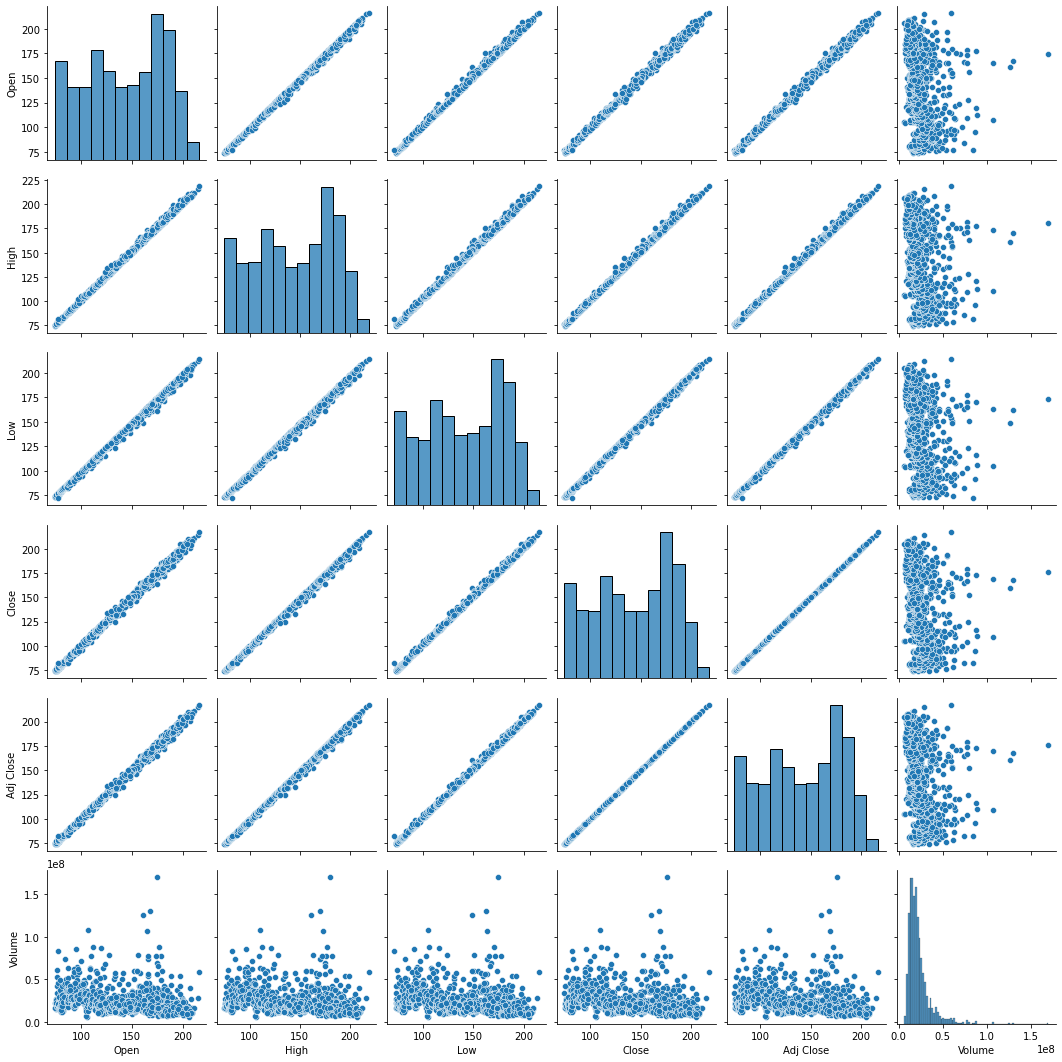

In [11]:
sns.pairplot(training_data)

We will need to select a specific type of stock price before proceeding. Let’s use Close, which indicates the unadjusted closing price of Facebook’s stock.
Now we need to select that column of the DataFrame and store it in a NumPy array. Here is the command to do this:

In [12]:
training_data = training_data.iloc[:, 4].values

In [15]:
type(training_data)

numpy.ndarray

In [16]:
from sklearn.preprocessing import MinMaxScaler

Next we need to create an instance of this class. We will assign the newly created object to a variable called scaler. We will be using the default parameters for this class, so we do not need to pass anything in:

In [17]:
scaler = MinMaxScaler()

We have created our scaler object but our training_data data set has not yet been scaled. We need to use the fit_transform method to modify the original data set. Here’s the statement to do this:

In [18]:
training_data = scaler.fit_transform(training_data.reshape(-1, 1))

The next thing we need to do is to specify our number of timesteps. Timesteps specify how many previous observations should be considered when the recurrent neural network makes a prediction about the current observation.
We will use 40 timesteps in this tutorial. This means that for every day that the neural network predicts, it will consider the previous 40 days of stock prices to determine its output. Note that since there are only ~20 trading days in a given month, using 40 timesteps means we’re relying on stock price data from the previous 2 months.


In [19]:
x_training_data = []

y_training_data =[]

Now we will use a for loop to populate the actual data into each of these Python lists. Here’s the code (with further explanation of the code after the code block):

In [20]:
for i in range(40, len(training_data)):
    x_training_data.append(training_data[i-40:i, 0])
    y_training_data.append(training_data[i, 0])

Let’s unpack the components of this code block:
 1. The range(40, len(training_data)) function causes the for loop to iterate from 40 to the last index of the training data.
 2. The x_training_data.append(training_data[i-40:i, 0]) line causes the loop to append the 40 preceding stock prices to x_training_data with each iteration of the loop.
 3. Similarly, the y_training_data.append(training_data[i, 0]) causes the loop to append the next day’s stock price to y_training_data with each iteration of the loop.


TensorFlow is designed to work primarily with NumPy arrays. Because of this, the last thing we need to do is transform the two Python lists we just created into NumPy arrays.
Fortunately, this is simple. You simply need to wrap the Python lists in the np.array function. Here’s the code:


In [21]:
x_training_data = np.array(x_training_data)

y_training_data = np.array(y_training_data)

One important way that you can make sure your script is running as intended is to verify the shape of both NumPy arrays.

The x_training_data array should be a two-directional NumPy array with one dimension being 40 (the number of timesteps) and the second dimension being len(training_data) - 40, which evaluates to 1218 in our case.

Similarly, the y_training_data object should be a one-dimensional NumPy array of length 1218 (which, again, is len(training_data) - 40).

You can verify the shape of the arrays by printing their shape attribute, like this:


In [22]:
print(x_training_data.shape)

print(y_training_data.shape)

(1218, 40)
(1218,)


Both arrays have the dimensions you’d expect. 

However, we need to reshape our x_training_data object one more time before proceeding to build our recurrent neural network.

The reason for this is that the recurrent neural network layer available in TensorFlow only accepts data in a very specific format. 

To reshape the x_training_data object, I will use the np.reshape method. Here’s the code to do this:


In [23]:
x_training_data = np.reshape(x_training_data, (x_training_data.shape[0], 

                                               x_training_data.shape[1], 

                                               1))

In [24]:
print(x_training_data.shape)

(1218, 40, 1)


Before we can begin building our recurrent neural network, we’ll need to import a number of classes from TensorFlow. Here are the statements you should run before proceeding:

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

It’s now time to build our recurrent neural network.

The first thing that needs to be done is initializing an object from TensorFlow’s Sequential class. As its name implies, the Sequential class is designed to build neural networks by adding sequences of layers over time.

Here’s the code to initialize our recurrent neural network:


In [26]:
rnn = Sequential()

The first layer that we will add is an LSTM layer. To do this, pass an invocation of the LSTM class (that we just imported) into the add method.

The LSTM class accepts several parameters. More precisely, we will specify three arguments:
 1. The number of LSTM neurons that you’d like to include in this layer. Increasing the number of neurons is one method for increasing the dimensionality of your recurrent neural network. In our case, we will specify units = 45.
 2. return_sequences = True - this must always be specified if you plan on including another LSTM layer after the one you’re adding. You should specify return_sequences = False for the last LSTM layer in your recurrent neural network.
 3. input_shape: the number of timesteps and the number of predictors in our training data. In our case, we are using 40 timesteps and only 1 predictor (stock price), so we will add


In [27]:
rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))

Note that I used x_training_data.shape[1] instead of the hardcoded value in case we decide to train the recurrent neural network on a larger model at a later date.

Dropout regularization is a technique used to avoid overfitting when training neural networks.

It involves randomly excluding - or “dropping out” - certain layer outputs during the training stage.

TensorFlow makes it easy to implement dropout regularization using the Dropout class that we imported earlier in our Python script. The Dropout class accepts a single parameter: the dropout rate.

The dropout rate indicates how many neurons should be dropped in a specific layer of the neural network. It is common to use a dropout rate of 20%. We will follow this convention in our recurrent neural network.

Here’s how you can instruct TensorFlow to drop 20% of the LSTM layer’s neuron during each iteration of the training stage:


In [28]:
rnn.add(Dropout(0.2))

We will now add three more LSTM layers (with dropout regularization) to our recurrent neural network. You will see that after specifying the first LSTM layer, adding more is trivial.

To add more layers, all that needs to be done is copying the first two add methods with one small change. Namely, we should remove the input_shape argument from the LSTM class.

We will keep the number of neurons (or units) and the dropout rate the same in each of the LSTM class invocations. Since the third LSTM layer we’re adding in this section will be our last LSTM layer, we can remove the return_sequences = True parameter as mentioned earlier. Removing the parameter sets return_sequences to its default value of False.


In [29]:
rnn.add(LSTM(units = 45, return_sequences = True))

rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))

rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45))

rnn.add(Dropout(0.2))

Let’s finish architecting our recurrent neural network by adding our output layer.

The output layer will be an instance of the Dense class, which is the same class we used to create the full connection layer of our convolutional neural network earlier in this course.

The only parameter we need to specify is units , which is the desired number of dimensions that the output layer should generate. Since we want to output the next day’s stock price (a single value), we’ll specify units = 1.


In [30]:
rnn.add(Dense(units = 1))

TensorFlow allows us to compile a neural network using the aptly-named compile method. It accepts two arguments: optimizer and loss.   

We now need to specify the optimizer and loss parameters.

Let’s start by discussing the optimizer parameter. Recurrent neural networks typically use the RMSProp optimizer in their compilation stage. With that said, we will use the Adam optimizer (as before). The Adam optimizer is a workhorse optimizer that is useful in a wide variety of neural network architectures.

The loss parameter is fairly simple. Since we’re predicting a continuous variable, we can use mean squared error - just like you would when measuring the performance of a linear regression machine learning model. This means we can specify loss = mean_squared_error.


In [31]:
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

It’s now time to train our recurrent network on our training data.

To do this, we use the fit method. The fit method accepts four arguments in this case:
 1. The training data: in our case, this will be x_training_data and y_training_data
 2. Epochs: the number of iterations you’d like the recurrent neural network to be trained on. We will specify epochs = 100 in this case.
 3. The batch size: the size of batches that the network will be trained in through each epoch.
 
Here is the code to train this recurrent neural network according to our specifications:


In [32]:
rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32)

Epoch 1/100
39/39 [==============================] - 2s 53ms/step - loss: 0.0384
Epoch 2/100
39/39 [==============================] - 2s 46ms/step - loss: 0.0073
Epoch 3/100
39/39 [==============================] - 2s 45ms/step - loss: 0.0064
Epoch 4/100
39/39 [==============================] - 2s 44ms/step - loss: 0.0061
Epoch 5/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0068
Epoch 6/100
39/39 [==============================] - 2s 43ms/step - loss: 0.0053
Epoch 7/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0050
Epoch 8/100
39/39 [==============================] - 2s 41ms/step - loss: 0.0058
Epoch 9/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0051
Epoch 10/100
39/39 [==============================] - 2s 41ms/step - loss: 0.0046
Epoch 11/100
39/39 [==============================] - 2s 40ms/step - loss: 0.0046
Epoch 12/100
39/39 [==============================] - 2s 40ms/step - loss: 0.0046
Epoch 13/100
39/39 [=====

You should see the loss function’s value slowly decline as the recurrent neural network is fitted to the training data over time. In my case, the loss function’s value declined from 0.0519 in the first iteration to 0.0016 in the last iteration.

We have built our recurrent neural network and trained it on data of Facebook’s stock price over the last 5 years. It’s now time to make some predictions!

To start, let’s import the actual stock price data for the first month of 2020. This will give us something to compare our predicted values to.
Here’s the code to do this. 

Note that it is very similar to the code that we used to import our training data at the start of our Python script:


In [33]:
test_data = pd.read_csv('data/FB_test_data.csv')

test_data = test_data.iloc[:, 4].values


In [34]:
print(test_data.shape)

(21,)


If you run the statement print(test_data.shape), it will return (21,). This shows that our test data is a one-dimensional NumPy array with 21 entries - which means there were 21 stock market trading days in January 2020.

You can also generate a quick plot of the data using plt.plot(test_data). 

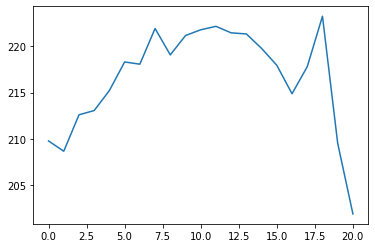

In [35]:
plt.plot(test_data)

Before we can actually make predictions for Facebook’s stock price in January 2020, we first need to make some changes to our data set.

The reason for this is that to predict each of the 21 observations in January, we will need the 40 previous trading days. Some of these trading days will come from the test set while the remainder will come from the training set. Because of this, some concatenation is necessary.

Unfortunately, you can just concatenate the NumPy arrays immediately. This is because we’ve already applied feature scaling to the training data but haven’t applied any feature scaling to the test data.

To fix this, we need to re-import the original x_training_data object under a new variable name called unscaled_x_training_data. For consistency, we will also re-import the test data as a DataFrame called unscaled_test_data:

In [50]:
unscaled_training_data = pd.read_csv('data/FB_training_data.csv')

unscaled_test_data = pd.read_csv('data/FB_test_data.csv')

Now we can concatenate together the Open column from each DataFrame with the following statement:

In [51]:
all_data=pd.concat((unscaled_training_data['Close'],unscaled_test_data['Close']), axis = 0)

Now we need to create an array of all the stock prices from January 2020 and the 40 trading days prior to January. 

We will call this object x_test_data since it contains the x values that we’ll use to make stock price predictions for January 2020.

The first thing you need to do is find the index of the first trading day in January within our all_data object. The statement len(all_data) - len(test_data) identifies this index for us.

This represents the upper bound of the first item in the array. To get the lower bound, just subtract 40 from this number. Said differently, the lower bound is len(all_data) - len(test_data) - 40.

The upper bound of the entire x_test_data array will be the last item in the data set. Accordingly, we can create this NumPy array with the following statement:    

In [52]:
x_test_data = all_data[len(all_data) - len(test_data) - 40:].values

You can check whether or not this object has been created as desired by printing len(x_test_data), which has a value of 61. 
This makes sense - it should contain the 21 values for January 2020 as well as the 40 values prior.

In [53]:
len(x_test_data)

61

The last step of this section is to quickly reshape our NumPy array to make it suitable for the predict method:

In [54]:
x_test_data = np.reshape(x_test_data, (-1, 1))

Our recurrent neural network was trained on scaled data. Because of this, we need to scale our x_test_data variable before we can use the model to make predictions.

In [55]:
x_test_data = scaler.transform(x_test_data)

Note that we used the transform method here instead of the fit_transform method (like before). This is because we want to transform the test data according to the fit generated from the entire training data set.

This means that the transformation that is applied to the test data will be the same as the one applied to the training data - which is necessary for our recurrent neural network to make accurate predictions.


The last thing we need to do is group our test data into 21 arrays of size 40. Said differently, we’ll now create an array where each entry corresponds to a date in January and contains the stock prices of the 40 previous trading days.

In [56]:
final_x_test_data = []

for i in range(40, len(x_test_data)):

    final_x_test_data.append(x_test_data[i-40:i, 0])

final_x_test_data = np.array(final_x_test_data)


Lastly, we need to reshape the final_x_test_data variable to meet TensorFlow standards.
We saw this previously, so the code should need no explanation:


In [57]:
final_x_test_data = np.reshape(final_x_test_data, (final_x_test_data.shape[0], final_x_test_data.shape[1],1))

After an absurd amount of data reprocessing, we are now ready to make predictions using our test data!

This step is simple. Simply pass in our final_x_test_data object into the predict method called on the rnn object. As an example, here is how you could generate these predictions and store them in an aptly-named variable called predictions:


In [58]:
predictions = rnn.predict(final_x_test_data)

Let’s plot these predictions by running plt.plot(predictions) 

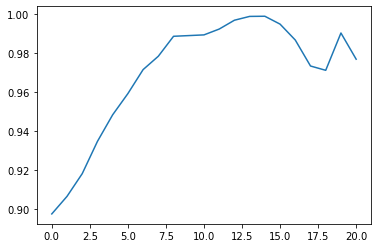

In [59]:
plt.plot(predictions) 

As you can see, the predicted values in this plot are all between 0 and 1. This is because our data set is still scaled! We need to un-scale it for the predictions to have any practical meaning.

The MinMaxScaler class that we used to originally scale our data set comes with a useful inverse_transform method to un-scale the data. Here’s how you could un-scale the data and generate a new plot:

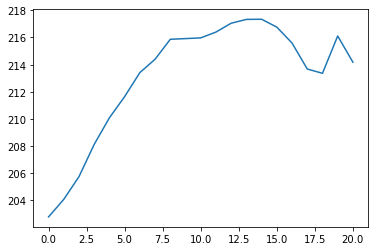

In [60]:
unscaled_predictions = scaler.inverse_transform(predictions)

plt.plot(unscaled_predictions)


Let’s generate plot that compares our predicted stock prices with Facebook’s actual stock price:

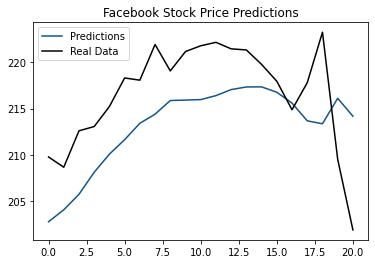

In [61]:
plt.plot(unscaled_predictions, color = '#135485', label = "Predictions")

plt.plot(test_data, color = 'black', label = "Real Data")

plt.title('Facebook Stock Price Predictions')

plt.legend()

In [64]:
print("The first trading day price prediction is for Jan 2020 is: ",unscaled_predictions[0])
print("The real first trading day price for Jan 2020 is: ",test_data[0])

The first trading day price prediction is for Jan 2020 is:  [202.7884]
The real first trading day price for Jan 2020 is:  209.77999900000003


In [65]:
print("The last trading day price prediction is for Jan 2020 is: ",unscaled_predictions[20])
print("The real last trading day price for Jan 2020 is: ",test_data[20])

The last trading day price prediction is for Jan 2020 is:  [214.17747]
The real last trading day price for Jan 2020 is:  201.91000400000001
